<a href="https://colab.research.google.com/github/sberniz/Electric_Cars/blob/master/Santiago_Berniz_Electric_Cars_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Electric Cars Manufacturer's Suggested Retail Price (MSRP) Prediction for Washinton State Registered Electric Cars

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/sberniz/build2/master/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
#Import all necesary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression,Ridge,RidgeCV
from scipy import stats
from category_encoders import OneHotEncoder, OrdinalEncoder
import plotly.express as px
from sklearn.preprocessing import StandardScaler


###CHOSEN DATASET

Washington State Registered Electric cars

In [2]:
electric_cars = pd.read_csv(DATA_PATH+'Electric_Vehicle_Population_Data.csv') #Load Dataset into a Pandas DataFrame
electric_cars.shape  #Shows shape of Dataset (rows,columns)

(58383, 15)

In [3]:
electric_cars.info() #information of Dataset. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58383 entries, 0 to 58382
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   VIN (1-10)                                         58383 non-null  object 
 1   County                                             58382 non-null  object 
 2   City                                               58383 non-null  object 
 3   State                                              58383 non-null  object 
 4   ZIP Code                                           58383 non-null  int64  
 5   Model Year                                         58383 non-null  int64  
 6   Make                                               58383 non-null  object 
 7   Model                                              58383 non-null  object 
 8   Electric Vehicle Type                              58383 non-null  object 
 9   Clean 

In [4]:
electric_cars.head()

,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
0,5YJ3E1EA9L,King,Auburn,WA,98001,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266,0,47.0,4759478,POINT (-122.266685 47.308313)
1,1FADP3R47E,King,Seattle,WA,98103,2014,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,76,29170,36.0,205611143,POINT (-122.343577 47.672491)
2,5YJSA1H1XE,King,Seattle,WA,98109,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,36.0,7424532,POINT (-122.346385 47.630685)
3,1N4BZ0CP9G,King,Seattle,WA,98103,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010,36.0,252339384,POINT (-122.343577 47.672491)
4,WBY1Z2C56E,King,Bellevue,WA,98006,2014,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,41350,41.0,213103376,POINT (-122.151342 47.560192)


In [5]:
electric_cars['Electric Vehicle Type'].value_counts()

Battery Electric Vehicle (BEV)            40596
Plug-in Hybrid Electric Vehicle (PHEV)    17787
Name: Electric Vehicle Type, dtype: int64

In [6]:
electric_cars['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts()

Clean Alternative Fuel Vehicle Eligible    47945
Not eligible due to low battery range      10438
Name: Clean Alternative Fuel Vehicle (CAFV) Eligibility, dtype: int64

In [7]:
electric_cars['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts(normalize=True) #Basemodel if going with clasification weather is eligible or not

Clean Alternative Fuel Vehicle Eligible    0.821215
Not eligible due to low battery range      0.178785
Name: Clean Alternative Fuel Vehicle (CAFV) Eligibility, dtype: float64


###EDA and Data Cleaning

In [8]:
electric_cars #exploring Dataset more

,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
0,5YJ3E1EA9L,King,Auburn,WA,98001,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266,0,47.0,4759478,POINT (-122.266685 47.308313)
1,1FADP3R47E,King,Seattle,WA,98103,2014,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,76,29170,36.0,205611143,POINT (-122.343577 47.672491)
2,5YJSA1H1XE,King,Seattle,WA,98109,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,36.0,7424532,POINT (-122.346385 47.630685)
3,1N4BZ0CP9G,King,Seattle,WA,98103,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010,36.0,252339384,POINT (-122.343577 47.672491)
4,WBY1Z2C56E,King,Bellevue,WA,98006,2014,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,41350,41.0,213103376,POINT (-122.151342 47.560192)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58378,JN1AZ0CP4B,Pierce,Tacoma,WA,98409,2011,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,32780,29.0,214353912,POINT (-122.480106 47.211446)
58379,1N4AZ1CP0J,King,Seattle,WA,98119,2018,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,151,29990,36.0,129767522,POINT (-122.36772100000002 47.639264)
58380,1N4AZ0CPXF,King,Seattle,WA,98115,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010,46.0,142752711,POINT (-122.297534 47.685291)
58381,5YJSA1CG2D,King,Seattle,WA,98106,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,34.0,237945956,POINT (-122.35495400000002 47.537664)


In [9]:
electric_cars.describe()

,ZIP Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID
count,58383.000000,58383.000000,58383.000000,58383.000000,58345.000000,5.838300e+04
mean,98216.009489,2016.718959,136.458216,37678.853519,30.431948,2.234009e+08
std,1427.145707,2.313965,92.494422,19681.979238,14.677599,1.338521e+08
min,320.000000,1993.000000,6.000000,0.000000,1.000000,1.949000e+03
25%,98052.000000,2015.000000,53.000000,29990.000000,21.000000,1.258541e+08
50%,98117.000000,2017.000000,107.000000,35000.000000,35.000000,2.054563e+08
75%,98354.000000,2018.000000,215.000000,39145.000000,43.000000,3.058830e+08
max,99403.000000,2020.000000,337.000000,845000.000000,49.000000,4.792548e+08


In [10]:
electric_cars.describe(exclude='number')

,VIN (1-10),County,City,State,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Vehicle Location
count,58383,58382,58383,58383,58383,58383,58383,58383,58381
unique,3942,66,427,15,29,94,2,2,535
top,5YJ3E1EB6J,King,Seattle,WA,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,POINT (-122.122018 47.678465)
freq,338,31937,11221,58345,21569,12741,40596,47945,1764


In [11]:
electric_cars['Base MSRP'].isnull().sum()

0

In [12]:
electric_cars['Electric Range'].value_counts()

215    6279
84     4178
220    3938
238    3450
19     2646
       ... 
170       2
59        1
57        1
80        1
39        1
Name: Electric Range, Length: 88, dtype: int64

In [13]:
electric_cars[electric_cars['Model Year'] == 1993]

,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
13429,2B4GH2595P,Thurston,Tumwater,WA,98501,1993,DODGE,CARAVAN,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,80,0,22.0,474727697,POINT (-122.87404199999999 46.998873)


In [14]:
electric_cars['Model Year'].value_counts()

2018    13475
2019     9998
2017     7722
2016     6305
2015     5109
2013     4955
2020     4279
2014     3789
2012     1773
2011      909
2010       31
2008       23
2000        7
2002        3
1999        2
1998        1
1997        1
1993        1
Name: Model Year, dtype: int64

In [15]:
electric_cars['Base MSRP'].describe()

count     58383.000000
mean      37678.853519
std       19681.979238
min           0.000000
25%       29990.000000
50%       35000.000000
75%       39145.000000
max      845000.000000
Name: Base MSRP, dtype: float64

In [16]:
df1 = electric_cars.copy() #Checking for outliers, that were spotted on the EDA. prices greater than $200,000
counterup = 0
counter845 = 0
for i, item in enumerate(df1['Base MSRP']):
  if item > 200000:
    counterup +=1
  if item >=845000:
    counter845 +=1
print("NUmber of price greater than 200,000",counterup)
print("NUmber of price grater than 845,000",counter845)

NUmber of price greater than 200,000 1
NUmber of price grater than 845,000 1


In [17]:
df1 = electric_cars.copy() #Checking for outliers, that were spotted on the EDA. prices less than $20,000
counter = 0
counterzero = 0
for i, item in enumerate(df1['Base MSRP']):
  if item < 20000:
    counter +=1
    if item == 0:
      counterzero +=1
print("NUmber of price less than 20000",counter)
print("NUmber of price at 0",counterzero)

NUmber of price less than 20000 4805
NUmber of price at 0 4805


In [18]:
#0 and 845,000 are outliers, will remove 
electric_cars['Base MSRP'] = electric_cars['Base MSRP'].replace({0:np.NaN,845000:np.NaN})
electric_cars.isnull().sum()

VIN (1-10)                                              0
County                                                  1
City                                                    0
State                                                   0
ZIP Code                                                0
Model Year                                              0
Make                                                    0
Model                                                   0
Electric Vehicle Type                                   0
Clean Alternative Fuel Vehicle (CAFV) Eligibility       0
Electric Range                                          0
Base MSRP                                            4806
Legislative District                                   38
DOL Vehicle ID                                          0
Vehicle Location                                        2
dtype: int64

In [19]:
electric_cars.dropna(subset=['Base MSRP'], inplace=True ) #drop NA values for base MSRP

In [20]:
electric_cars

,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
1,1FADP3R47E,King,Seattle,WA,98103,2014,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,76,29170.0,36.0,205611143,POINT (-122.343577 47.672491)
2,5YJSA1H1XE,King,Seattle,WA,98109,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900.0,36.0,7424532,POINT (-122.346385 47.630685)
3,1N4BZ0CP9G,King,Seattle,WA,98103,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010.0,36.0,252339384,POINT (-122.343577 47.672491)
4,WBY1Z2C56E,King,Bellevue,WA,98006,2014,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,41350.0,41.0,213103376,POINT (-122.151342 47.560192)
5,1G1FW6S04J,Thurston,Olympia,WA,98501,2018,CHEVROLET,BOLT,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,37495.0,22.0,152207093,POINT (-122.87404199999999 46.998873)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58378,JN1AZ0CP4B,Pierce,Tacoma,WA,98409,2011,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,32780.0,29.0,214353912,POINT (-122.480106 47.211446)
58379,1N4AZ1CP0J,King,Seattle,WA,98119,2018,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,151,29990.0,36.0,129767522,POINT (-122.36772100000002 47.639264)
58380,1N4AZ0CPXF,King,Seattle,WA,98115,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010.0,46.0,142752711,POINT (-122.297534 47.685291)
58381,5YJSA1CG2D,King,Seattle,WA,98106,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900.0,34.0,237945956,POINT (-122.35495400000002 47.537664)


In [21]:
from pandas_profiling import ProfileReport  ##more EDA from Pandas profiling
profile = ProfileReport(electric_cars,minimal=True).to_notebook_iframe()

In [22]:
electric_cars['Make'].value_counts(dropna=False)

TESLA                   18159
NISSAN                  11021
CHEVROLET                7525
FORD                     3602
BMW                      2576
TOYOTA                   2522
KIA                      2115
AUDI                      773
CHRYSLER                  751
HYUNDAI                   716
FIAT                      701
HONDA                     591
VOLVO                     579
VOLKSWAGEN                473
MITSUBISHI                377
SMART                     242
PORSCHE                   233
MERCEDES-BENZ             214
MINI                      133
JAGUAR                    105
CADILLAC                   95
SUBARU                     39
FISKER                     18
AZURE DYNAMICS              9
LINCOLN                     6
WHEEGO ELECTRIC CARS        2
Name: Make, dtype: int64

In [23]:
electric_cars['Model'].value_counts(dropna=False)

LEAF                                   11021
MODEL 3                                10175
MODEL S                                 5506
VOLT                                    4675
BOLT                                    2617
                                       ...  
LIFE                                       2
Q5 E                                       2
PRIUS PLUG-IN HYBRID                       1
500                                        1
FUSION SPECIAL SERVICE VEHICLE PHEV        1
Name: Model, Length: 80, dtype: int64

In [24]:
electric_cars['Model Year'].value_counts()

2018    13473
2019     9457
2017     7718
2016     6305
2015     5108
2013     4955
2014     3789
2012     1773
2011      905
2020       40
2010       31
2008       23
Name: Model Year, dtype: int64

In [25]:
electric_cars.isnull().sum()

VIN (1-10)                                            0
County                                                1
City                                                  0
State                                                 0
ZIP Code                                              0
Model Year                                            0
Make                                                  0
Model                                                 0
Electric Vehicle Type                                 0
Clean Alternative Fuel Vehicle (CAFV) Eligibility     0
Electric Range                                        0
Base MSRP                                             0
Legislative District                                 36
DOL Vehicle ID                                        0
Vehicle Location                                      2
dtype: int64

In [26]:
electric_cars['Base MSRP'].value_counts()

36000.0    6260
35000.0    3915
29010.0    3243
29990.0    2759
69900.0    2570
           ... 
30315.0       3
81100.0       3
91250.0       3
94400.0       2
45490.0       1
Name: Base MSRP, Length: 149, dtype: int64

###Data Wrangling and Train/ Val / Test splits

In [27]:
#Will use make, model, and model year might add other features
#Will do a randomsplit test
#This Function will first remove the target label, Base MSRP to prevent leakage. and then split between Train and Test subsets
def wrangle1split(df):
  X = df.copy()
  y = X['Base MSRP']
  X = X[['Model Year','Make','Model','Electric Vehicle Type','Clean Alternative Fuel Vehicle (CAFV) Eligibility','Electric Range']]
  X_train,X_val,y_train,y_val = train_test_split(X,y,train_size = 0.8, test_size=0.2,random_state=42)
  return X_train, X_val, y_train, y_val

In [28]:
#Removing Problematic rows Car Model not used often. unable to get model name after encoding
electric_cars = electric_cars.drop(11853) 
electric_cars = electric_cars.drop(25326)

In [29]:
X_train ,X_test, y_train, y_test = wrangle1split(electric_cars) #Train Test SPlit
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,train_size=0.8, random_state=42) #Train/Validation Split

In [30]:
#Check the split did not loose any data. 
assert electric_cars.drop(columns='Base MSRP').shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

In [31]:
y_train.head()

57105    35000.0
35423    36000.0
39049    36000.0
25870    28500.0
7037     96100.0
Name: Base MSRP, dtype: float64

In [32]:
X_train.shape, X_val.shape,X_test.shape

((34288, 6), (8572, 6), (10715, 6))

In [33]:
X_train.head()

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range
57105,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220
35423,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215
39049,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215
25870,2019,KIA,NIRO PLUG-IN HYBRID,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26
7037,2016,PORSCHE,PANAMERA,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,15


In [34]:
X_val

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range
17079,2017,FIAT,500E,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84
56401,2019,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,289
46780,2016,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210
17299,2018,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,151
44313,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84
...,...,...,...,...,...,...
11598,2015,FORD,FUSION ENERGI,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19
26683,2018,TOYOTA,PRIUS PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25
53257,2017,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,107
11999,2017,FORD,C-MAX ENERGI,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,20


In [35]:
X_train.nunique()

Model Year                                           12
Make                                                 26
Model                                                78
Electric Vehicle Type                                 2
Clean Alternative Fuel Vehicle (CAFV) Eligibility     2
Electric Range                                       72
dtype: int64

###Exploratory Plots

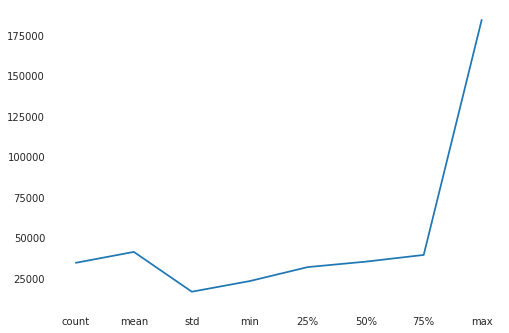

In [36]:
y_train.describe().plot();

In [37]:
X_train.describe()

,Model Year,Electric Range
count,34288.000000,34288.000000
mean,2016.446716,126.196395
std,2.182682,84.989957
min,2008.000000,6.000000
25%,2015.000000,47.000000
50%,2017.000000,93.000000
75%,2018.000000,215.000000
max,2020.000000,289.000000


In [38]:
X_train.describe(exclude='number')

,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility
count,34288,34288,34288,34288
unique,26,78,2,2
top,TESLA,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible
freq,11699,7042,23201,27920


0

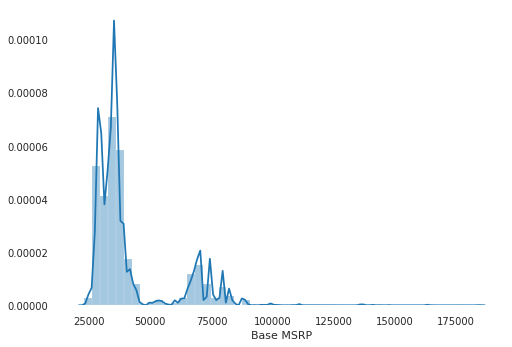

In [39]:
sns.distplot(y_train); 0 #Density Plot

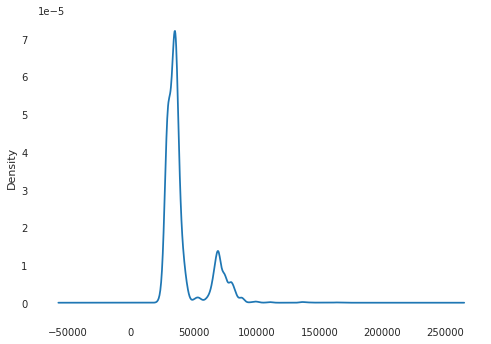

In [40]:
y_train.plot.density();

In [41]:
X_train.head(1)

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range
57105,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220


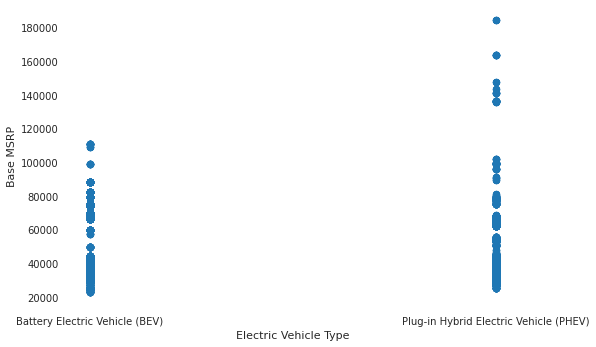

In [42]:
plt.scatter(X_train['Electric Vehicle Type'],y_train)
plt.ylabel("Base MSRP")
plt.xlabel("Electric Vehicle Type");

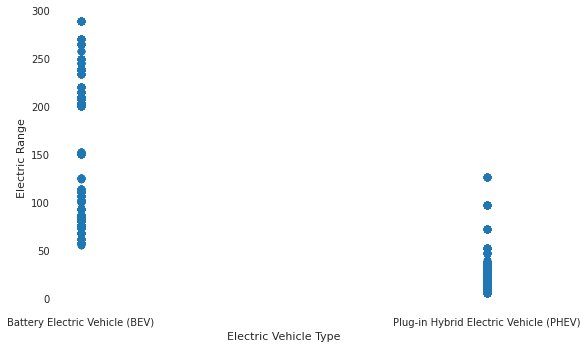

In [43]:
plt.scatter(X_train['Electric Vehicle Type'],X_train['Electric Range'])
plt.ylabel("Electric Range")
plt.xlabel("Electric Vehicle Type");

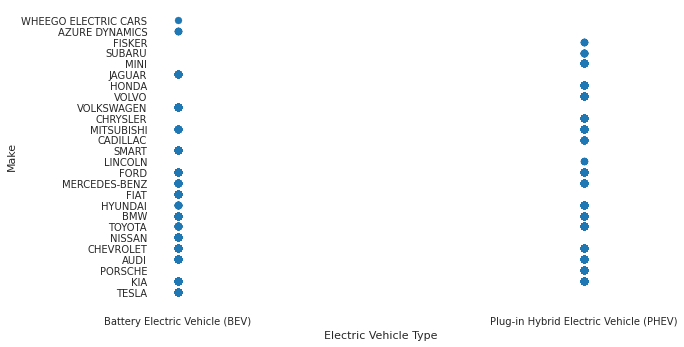

In [44]:
plt.scatter(X_train['Electric Vehicle Type'],X_train['Make'])
plt.ylabel("Make")
plt.xlabel("Electric Vehicle Type");

###Baseline Model

In [45]:
#Baseline Model 
y_train_mean = y_train.mean() #Baseline if going to predict base msrp
y_train_pred_base =[y_train_mean]*len(y_train)
print("Base MSRP Mean:",y_train_mean)
print("Base Model MAE:",mean_absolute_error(y_train_pred_base,y_train))
print("r2 Score",r2_score(y_train,y_train_pred_base))
y_train_base = [y_train.mean()]*len(y_train)

Base MSRP Mean: 41024.24317545497
Base Model MAE: 12072.210704377852
r2 Score 0.0


In [46]:
 #Second way to test for baseline
errors = y_train_mean - y_train
mean_absolute_error1 = errors.abs().mean()
mean_absolute_error1

12072.210704375446

###Linear Model

In [47]:
lin_model = make_pipeline(
  OneHotEncoder(use_cat_names=True),
  SimpleImputer(),
  LinearRegression()
)
lin_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Make', 'Model', 'Electric Vehicle Type',
                                     'Clean Alternative Fuel Vehicle (CAFV) '
                                     'Eligibility'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [48]:
#Model Scores for Linear Model
print("Train Score",lin_model.score(X_train,y_train))
print("Validation Score",lin_model.score(X_val,y_val))
y_lin_train_pred = lin_model.predict(X_train)
y_lin_val_pred = lin_model.predict(X_val)
print("\nTrain Mean Absolute Error:",mean_absolute_error(y_train,y_lin_train_pred))
print("Validation Mean Absolute Error:",mean_absolute_error(y_val,y_lin_val_pred))

Train Score 0.9842076302741715
Validation Score 0.9848133253244428

Train Mean Absolute Error: 1064.6711237853656
Validation Mean Absolute Error: 1073.0619387482827


In [49]:
print("Model HyperParameters:")
print(lin_model.named_steps['linearregression'])

Model HyperParameters:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [50]:
#Linear Model Ridge
lin_model_ridge = make_pipeline(
  OneHotEncoder(use_cat_names=True),
  SimpleImputer(),
  Ridge(normalize=True)
)
lin_model_ridge.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Make', 'Model', 'Electric Vehicle Type',
                                     'Clean Alternative Fuel Vehicle (CAFV) '
                                     'Eligibility'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=True, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [51]:
print("Ridge Trainig r2score:",lin_model_ridge.score(X_train,y_train))
print("Ridge Validation r2score:",lin_model_ridge.score(X_val,y_val))
y_ridge_pred = lin_model_ridge.predict(X_val)
print("Ridge Validation mean absolute Error:",mean_absolute_error(y_ridge_pred,y_val))

Ridge Trainig r2score: 0.8234288528046889
Ridge Validation r2score: 0.8237602355855449
Ridge Validation mean absolute Error: 4990.77126201189


In [52]:
#Randomizedd cv search to select best Hyperparameters
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median','most_frequent','constant'],
    'ridge__alpha':[0,0.1,1,10,15,20]
}
search = RandomizedSearchCV(lin_model_ridge,
                            param_distributions=param_distributions,n_iter=10,
                            cv=3,
                            scoring='neg_mean_absolute_error',
                            verbose=10,
                            return_train_score=True,
                            
                            n_jobs=-1
                            )
search.fit(X_train,y_train);


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.4s finished


In [53]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'constant', 'ridge__alpha': 0.1}
Cross-validation MAE 1420.7351350899798


In [54]:
y_search_pred=search.predict(X_val) #Validation prediction with best hyper parameters
print("r2 score with Ridge Linear Regression:",r2_score(y_val,y_search_pred))
print("Mean absolute error of Validation with Ridge Linear Regression:",mean_absolute_error(y_val,y_search_pred))

r2 score with Ridge Linear Regression: 0.9799827725906894
Mean absolute error of Validation with Ridge Linear Regression: 1434.3362093203416


###Tree Base Model

In [55]:
#Random Forest with Ordinal Encoding 
modelord = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestRegressor(random_state=42)
)
modelord.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Make', 'Model', 'Electric Vehicle Type',
                                      'Clean Alternative Fuel Vehicle (CAFV) '
                                      'Eligibility'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Make',
                                          'data_type': dtype('O'),
                                          'mapping': TESLA                    1
KIA                      2
PORSCHE                  3
AUDI                     4
CHEVROLET                5
NISSAN                   6
TOYOTA                   7
BMW                      8
HYUNDAI                  9
FIAT                    10
MERCEDES...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=N

In [56]:
print("Training Score:",modelord.score(X_train,y_train))
print("Validation Score:",modelord.score(X_val,y_val))
y_pred_tr2 = modelord.predict(X_train)
y_val23 = modelord.predict(X_val)
print("Training MAE:",mean_absolute_error(y_train,y_pred_tr2))
print("Validation MAE:",mean_absolute_error(y_val,y_val23))

Training Score: 0.9999886153099309
Validation Score: 0.9999878850337705
Training MAE: 0.8525081661222588
Validation MAE: 1.5766623891740574


In [57]:
#RandomForest with OneHot Encoding
model1 = make_pipeline(OneHotEncoder(use_cat_names=True),
                       SimpleImputer(),
                       RandomForestRegressor(random_state=42)
)
model1.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Make', 'Model', 'Electric Vehicle Type',
                                     'Clean Alternative Fuel Vehicle (CAFV) '
                                     'Eligibility'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                   

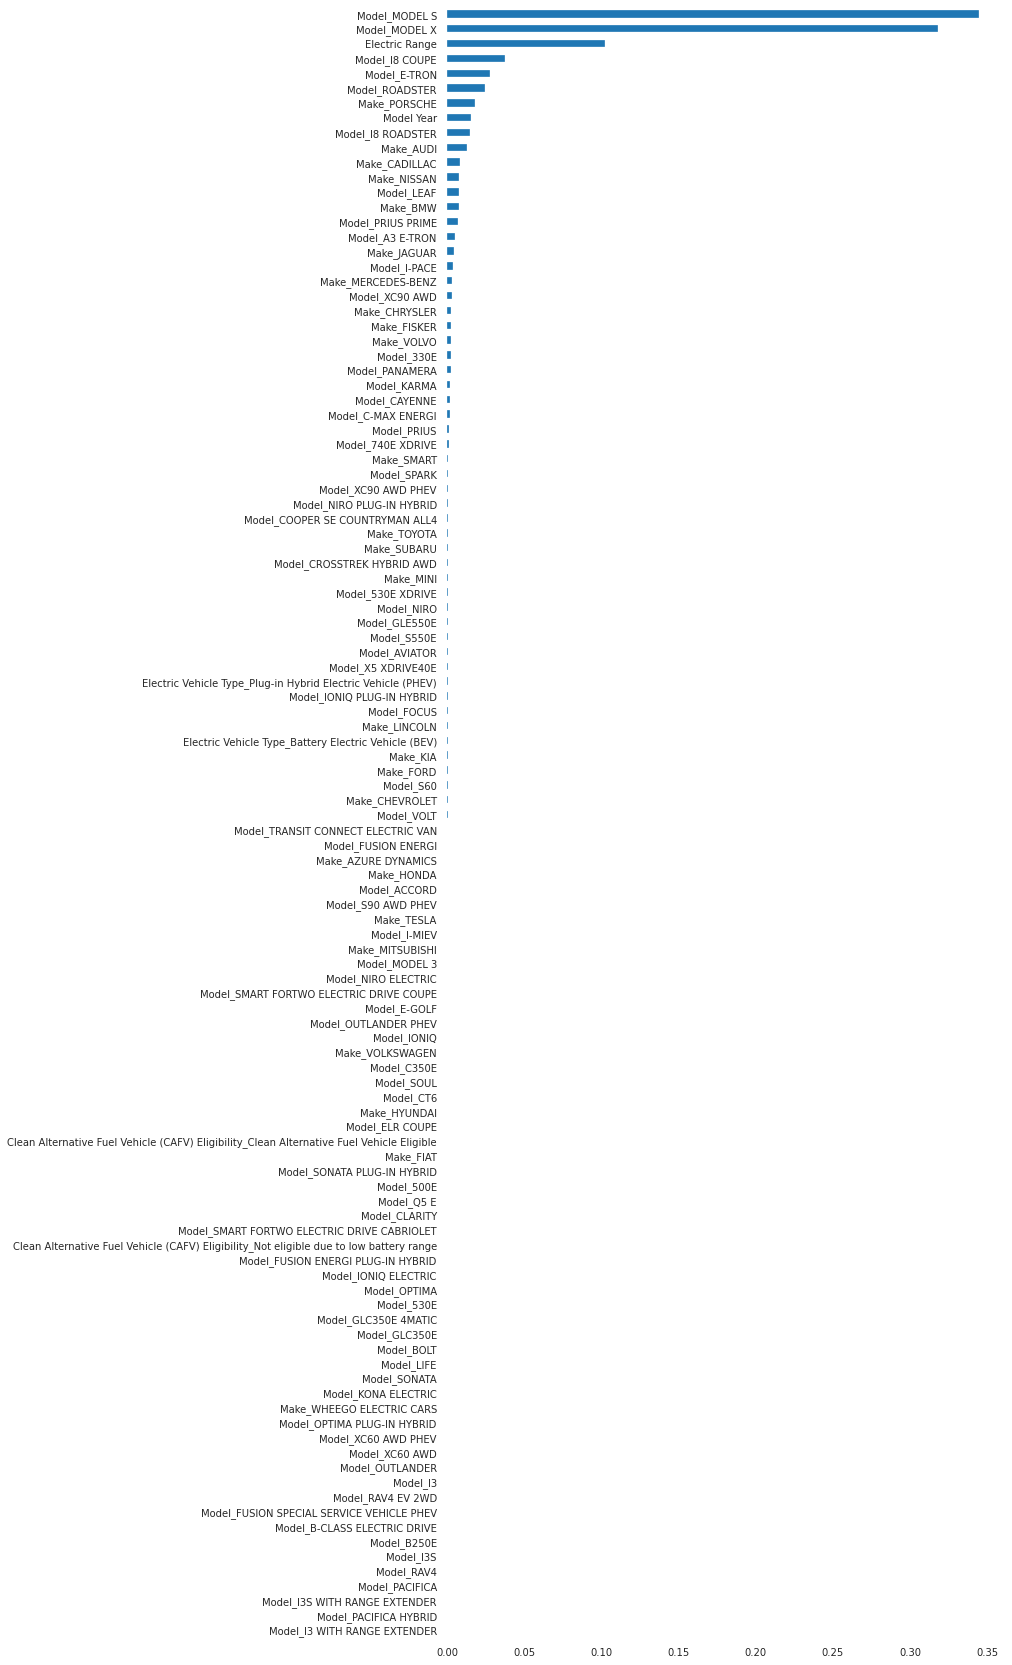

In [58]:
#Feature Importance Graph
model = model1.named_steps['randomforestregressor']
encoder_imp = model1.named_steps['onehotencoder']
encoded_columns = encoder_imp.transform(X_val).columns
importances = pd.Series(model.feature_importances_,encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

In [59]:
print("Training Score:",model1.score(X_train,y_train))
print("Validation Score:",model1.score(X_val,y_val))

Training Score: 0.9999957102664055
Validation Score: 0.9998078800757512


In [60]:
y_train_pred = model1.predict(X_train)
y_val_pred = model1.predict(X_val)
y_test_pred = model1.predict(X_test)

In [61]:
print("Training r2score:",r2_score(y_train,y_train_pred))
print("Val r2score",r2_score(y_val,y_val_pred))
print("\nTraining mean absolute error",mean_absolute_error(y_train,y_train_pred))
print("Validation mean absolute error",mean_absolute_error(y_val,y_val_pred))
print("Test mean absolute error",mean_absolute_error(y_test,y_test_pred))

Training r2score: 0.9999957102664055
Val r2score 0.999807880075751

Training mean absolute error 0.7173092627158201
Validation mean absolute error 4.289057396173591
Test mean absolute error 2.5335277648156804


###Small Try with Electric Range as Target to see difference

In [62]:
y_range = electric_cars['Electric Range']
X_range = electric_cars[['Model Year','Make','Model','Electric Vehicle Type','Clean Alternative Fuel Vehicle (CAFV) Eligibility','Base MSRP']]

In [63]:
X_range.head()

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Base MSRP
1,2014,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,29170.0
2,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,69900.0
3,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,29010.0
4,2014,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,41350.0
5,2018,CHEVROLET,BOLT,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,37495.0


In [64]:
electric_cars['Electric Range'].isnull().sum()

0

In [65]:
X_range_train,X_range_val,y_range_train,y_range_val = train_test_split(X_range,y_range,train_size=0.8,test_size=0.2,random_state=42)

In [66]:
assert X_range.shape[0] == X_range_train.shape[0] + X_range_val.shape[0]

In [67]:
modelrange = make_pipeline(OneHotEncoder(),
                           SimpleImputer(),
                           RandomForestClassifier(random_state=42)
                           )

modelrange.fit(X_range_train,y_range_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Make', 'Model', 'Electric Vehicle Type',
                                     'Clean Alternative Fuel Vehicle (CAFV) '
                                     'Eligibility'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease

In [68]:
print("Training Score:",modelrange.score(X_range_train,y_range_train))
print("Validation Score:",modelrange.score(X_range_val,y_range_val))

Training Score: 0.9998600093327111
Validation Score: 0.9999066728884741


###XGBoost Model


In [69]:
#XGBOOST MODEL with no tuning
from xgboost import XGBRegressor

In [70]:
modelxg1 = make_pipeline(OrdinalEncoder(),
                         XGBRegressor(n_estimators=100,random_state=42))
modelxg1.fit(X_train,y_train)

[17:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Make', 'Model', 'Electric Vehicle Type',
                                      'Clean Alternative Fuel Vehicle (CAFV) '
                                      'Eligibility'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Make',
                                          'data_type': dtype('O'),
                                          'mapping': TESLA                    1
KIA                      2
PORSCHE                  3
AUDI                     4
CHEVROLET                5
NISSAN                   6
TOYOTA                   7
BMW                      8
HYUNDAI                  9
FIAT                    10
MERCEDES...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
       

In [71]:
print("Training accuracy:",modelxg1.score(X_train,y_train))
print("Validation accuracy:",modelxg1.score(X_val,y_val))

Training accuracy: 0.965781528478157
Validation accuracy: 0.963900954260928


In [72]:
#XG Boost Regression with early stopping and hyper parameter tuning, best model , will be deployment for post/app
processor = OrdinalEncoder()
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)
X_test_processed= processor.transform(X_test)

modeltb = XGBRegressor(
    n_estimators = 4000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1,
    random_state=42
)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

modeltb.fit(X_train_processed, y_train, 
          eval_set=eval_set, 
          eval_metric='rmse', 
          early_stopping_rounds=50) # Stop if the score hasn't improved in 50 rounds

[17:42:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:22265	validation_1-rmse:22364.3
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:11258.4	validation_1-rmse:11306.3
[2]	validation_0-rmse:5768.6	validation_1-rmse:5816.15
[3]	validation_0-rmse:3040.32	validation_1-rmse:3066.83
[4]	validation_0-rmse:1709.19	validation_1-rmse:1742.15
[5]	validation_0-rmse:1003.95	validation_1-rmse:1035.57
[6]	validation_0-rmse:673.667	validation_1-rmse:703.498
[7]	validation_0-rmse:509.136	validation_1-rmse:526.66
[8]	validation_0-rmse:433.4	validation_1-rmse:454.061
[9]	validation_0-rmse:390.194	validation_1-rmse:408.577
[10]	validation_0-rmse:275.661	validation_1-rmse:299.022
[11]	validation_0-rmse:211.283	validation_1-rmse:247.071
[12]	validation_0-rmse:189.005	validation_1-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=4000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [73]:
y_tb_train_pred = modeltb.predict(X_train_processed)
y_tb_val_pred = modeltb.predict(X_val_processed)
y_tb_test_pred = modeltb.predict(X_test_processed)
print("Train r2 score:",r2_score(y_train,y_tb_train_pred))
print("Validation r2 score:",r2_score(y_val,y_tb_val_pred))
print("Test r2 score:",r2_score(y_test,y_tb_test_pred))

print("\nTrain Mean Absolute Error:",mean_absolute_error(y_train,y_tb_train_pred))
print("Validation Mean Absolute Error:",mean_absolute_error(y_val,y_tb_val_pred))
print("Test mean Absolute Error:",mean_absolute_error(y_test,y_tb_test_pred))

Train r2 score: 0.9999999819326266
Validation r2 score: 0.9999889015306334
Test r2 score: 0.9999966384449898

Train Mean Absolute Error: 0.6441519946847294
Validation Mean Absolute Error: 1.5962684193449603
Test mean Absolute Error: 0.9601547917638824


###Permutation Importances

In [74]:
#Permutation importance sklearn
from sklearn.inspection import  permutation_importance

In [75]:
result = permutation_importance(modeltb,X_val_processed,y_val,n_repeats=5,random_state=0)

In [76]:
df = pd.DataFrame({'feature':X_val.columns,
                   'importances_mean':np.round(result['importances_mean'],3),
                   'importances_std':result['importances_std']})

In [77]:
df.sort_values(by='importances_mean',ascending=False)

,feature,importances_mean,importances_std
1,Make,1.778,0.016532
2,Model,1.322,0.023871
5,Electric Range,0.635,0.011897
0,Model Year,0.073,0.000875
3,Electric Vehicle Type,0.018,0.000794
4,Clean Alternative Fuel Vehicle (CAFV) Eligibility,0.001,0.000090


In [78]:
#With eli5
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 2.6MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.


In [79]:
permuter = PermutationImportance(
    modeltb,
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_processed,y_val)


PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.5,
                                             max_delta_step=0, max_depth=7,
                                             min_child_weight=1, missing=None,
                                             n_estimators=4000, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=42, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                    

In [80]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val_processed.columns.tolist()
)

Weight,Feature
1.7795 ± 0.0466,Make
1.3262 ± 0.0075,Model
0.6291 ± 0.0151,Electric Range
0.0733 ± 0.0040,Model Year
0.0183 ± 0.0023,Electric Vehicle Type
0.0009 ± 0.0002,Clean Alternative Fuel Vehicle (CAFV) Eligibility


###Partial Dependent Plot

In [81]:
!pip install pdp

  Created wheel for pdp: filename=pdp-0.3.0-cp36-none-any.whl size=6603 sha256=14f82aa0656f7e39c7bd5243b8e1ac10ecb6349d6844ee0f2788508188914eba
  Stored in directory: /root/.cache/pip/wheels/84/fb/5e/afb783110614b3c1a4187e6f83e4f4ea0088fbdb82921013a2
Successfully built pdp


In [82]:
!pip install pdpbox


     |████████████████████████████████| 57.7MB 71kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=bb90b6739229045ad9445d483d94b4e59eb00c64a392ddd1df7e090e29785454
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [83]:
plt.rcParams['figure.dpi'] = 72

In [84]:
from pdpbox.pdp import pdp_isolate,pdp_plot

In [85]:
feature = 'Electric Range'
isolated = pdp_isolate(
    model=modeltb,
    dataset=X_val_processed,
    model_features=X_val_processed.columns,
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


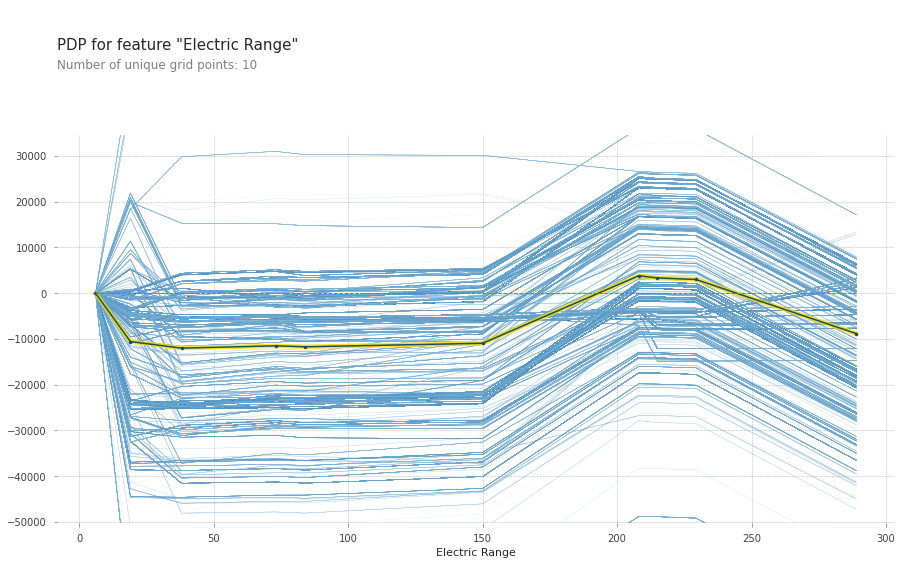

In [86]:
pdp_plot(isolated,feature_name=feature,plot_lines=True);

In [87]:
#Partial dependence with two features
from pdpbox.pdp import pdp_interact,pdp_interact_plot

In [88]:
features=['Model Year','Electric Range']
interaction = pdp_interact(
    model=modeltb,
    dataset=X_val_processed,
    model_features=X_val_processed.columns,
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


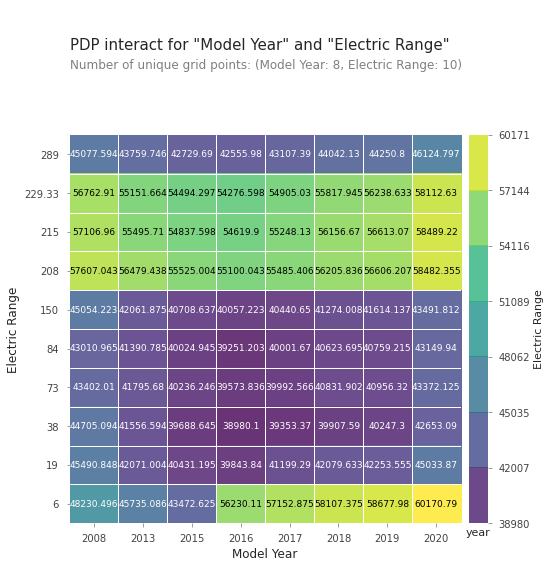

In [89]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)
plt.xlabel("year")
plt.ylabel("Electric Range");

In [90]:
y_test2 = modeltb.predict(X_test_processed)

In [91]:
mean_absolute_error(y_test,y_test2)

0.9601547917638824

In [92]:
from pdpbox import pdp


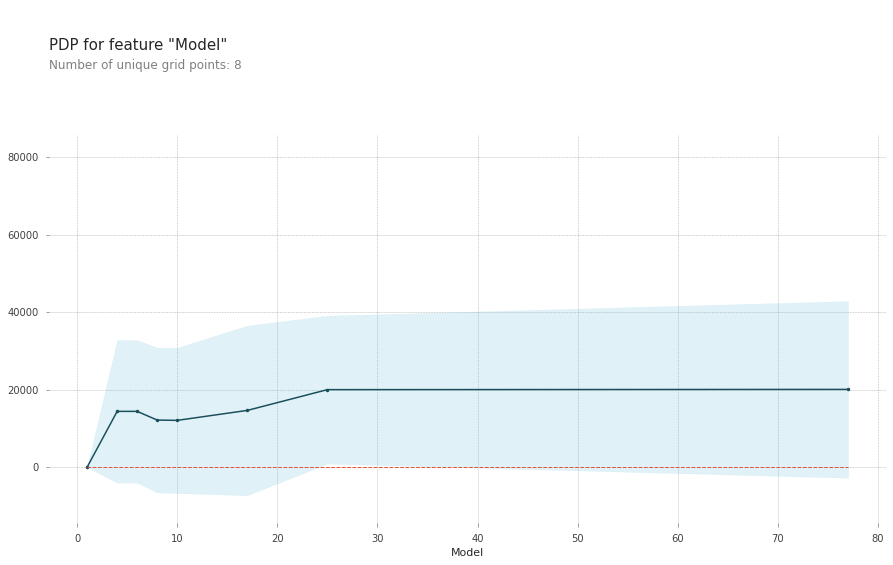

In [93]:
feature='Model'
pdp_dist= pdp_isolate(
    model=modeltb,
    dataset=X_val_processed,
    model_features=X_val_processed.columns,
    feature=feature
)
pdp.pdp_plot(pdp_dist, feature);

In [94]:
processor.mapping[1]

{'col': 'Model',
 'data_type': dtype('O'),
 'mapping': MODEL 3                                 1
 NIRO PLUG-IN HYBRID                     2
 PANAMERA                                3
 MODEL S                                 4
 E-TRON                                  5
                                        ..
 IONIQ                                  75
 IONIQ ELECTRIC                         76
 Q5 E                                   77
 FUSION SPECIAL SERVICE VEHICLE PHEV    78
 NaN                                    -2
 Length: 79, dtype: int64}

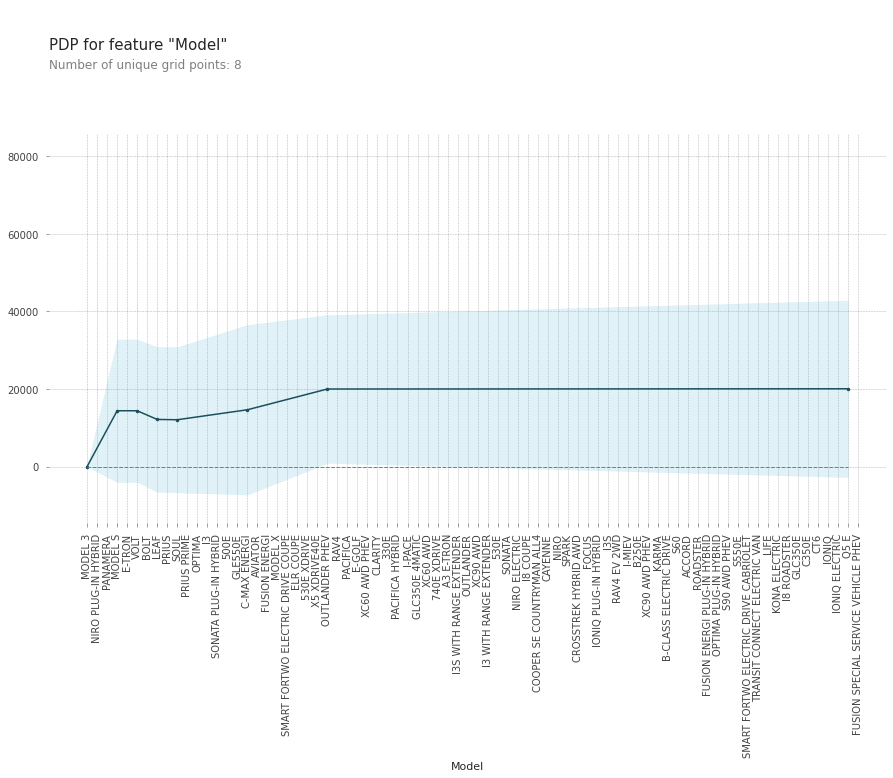

In [95]:
feature='Model'
for item in processor.mapping:
  if item['col'] == feature:
    feature_mapping = item['mapping']
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names= feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()
pdp.pdp_plot(pdp_dist,feature)
plt.xticks(category_codes,category_names,rotation='vertical');

In [96]:
category_names

['MODEL 3',
 'NIRO PLUG-IN HYBRID',
 'PANAMERA',
 'MODEL S',
 'E-TRON',
 'VOLT',
 'BOLT',
 'LEAF',
 'PRIUS',
 'SOUL',
 'PRIUS PRIME',
 'OPTIMA',
 'I3',
 'SONATA PLUG-IN HYBRID',
 '500E',
 'GLE550E',
 'C-MAX ENERGI',
 'AVIATOR',
 'FUSION ENERGI',
 'MODEL X',
 'SMART FORTWO ELECTRIC DRIVE COUPE',
 'ELR COUPE',
 '530E XDRIVE',
 'X5 XDRIVE40E',
 'OUTLANDER PHEV',
 'RAV4',
 'PACIFICA',
 'E-GOLF',
 'XC60 AWD PHEV',
 'CLARITY',
 '330E',
 'PACIFICA HYBRID',
 'I-PACE',
 'GLC350E 4MATIC',
 'XC60 AWD',
 '740E XDRIVE',
 'A3 E-TRON',
 'I3S WITH RANGE EXTENDER',
 'OUTLANDER',
 'XC90 AWD',
 'I3 WITH RANGE EXTENDER',
 '530E',
 'SONATA',
 'NIRO ELECTRIC',
 'I8 COUPE',
 'COOPER SE COUNTRYMAN ALL4',
 'CAYENNE',
 'NIRO',
 'SPARK',
 'CROSSTREK HYBRID AWD',
 'FOCUS',
 'IONIQ PLUG-IN HYBRID',
 'I3S',
 'RAV4 EV 2WD',
 'I-MIEV',
 'B250E',
 'XC90 AWD PHEV',
 'KARMA',
 'B-CLASS ELECTRIC DRIVE',
 'S60',
 'ACCORD',
 'ROADSTER',
 'FUSION ENERGI PLUG-IN HYBRID',
 'OPTIMA PLUG-IN HYBRID',
 'S90 AWD PHEV',
 'S550E',
 

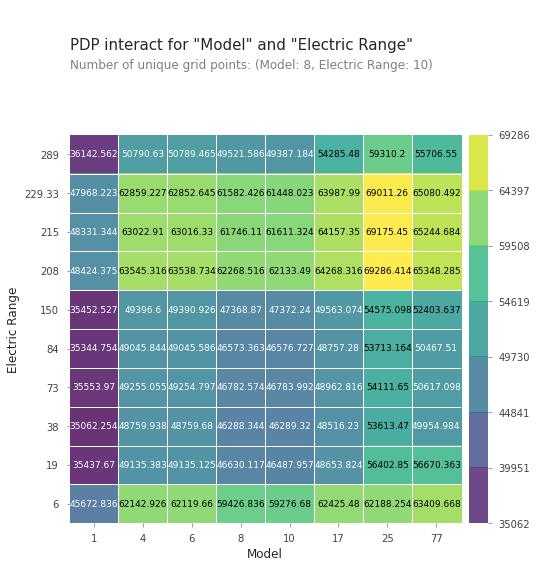

In [97]:
features1 = ['Model','Electric Range']
interaction2 = pdp_interact(
    model = modeltb,
    dataset=X_val_processed,
    model_features=X_val_processed.columns,
    features=features1
)
pdp_interact_plot(interaction2,plot_type='grid', feature_names=features1);

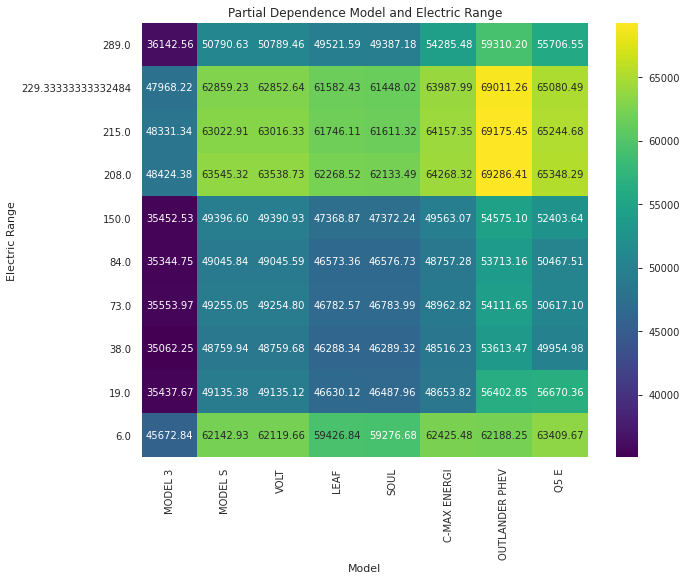

In [98]:
pdp = interaction2.pdp.pivot_table(
    values='preds', 
    columns=features1[0], # First feature on x axis
    index=features1[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending
pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
pdp
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence Model and Electric Range');


### Shapley Values

In [99]:
#Row chosen to predict a single item
row = X_val_processed.iloc[[10]]
row

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range
27352,2013,6,8,1,1,75


In [100]:
y_val.iloc[[10]]

27352    28800.0
Name: Base MSRP, dtype: float64

In [101]:
modeltb.predict(row)

array([28800.22], dtype=float32)

In [102]:
!pip install shap

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394118 sha256=03c37218bdf2d818f0edc9972ef0836b89039d8bbc9a9d25fe634bceea839602
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [103]:
#SHAPLEY VALUES
import shap

In [104]:
explainer = shap.TreeExplainer(modeltb)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

###Graph Exports

In [105]:

!pip install -q chart_studio
import plotly.express as px #Plotly Express
import plotly.io as pio #To convert to html
import plotly.graph_objects as go #plotly go
import chart_studio #chartstudio
import chart_studio.plotly as py
username = 'sberniz' #username
api_key = '5Ob9KVbdyKgJcdT3hEFP' #api key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key) #connect to api

     |████████████████████████████████| 71kB 2.0MB/s 


In [106]:
fig = px.scatter(X_test_processed,x='Model',y='Electric Range', title='Price According To Electric Range and Car Model',color=y_tb_test_pred)
fig.update_layout(xaxis_title="",yaxis_title='Electric Range',xaxis=dict(tickmode='array',tickvals=category_codes,ticktext=category_names))
fig.show()

In [107]:

#Link to chart
py.plot(fig, filename = 'fig', auto_open=True)

'https://plotly.com/~sberniz/29/'

# **BLOG POST LINK**

[Electric Car Prices Predictions](https://medium.com/@sberniz/electric-car-prices-registered-in-washington-state-59e34f9b88d6)